#1. Problem Definition & Understanding

Problem- Telecom and subscription-based businesses need to identify which customers are likely to cancel
their service. Preventing churn is more cost-effective than acquiring new users.

Goal: Predict whether a customer will churn based on usage and interaction data.

#2. Load Data & Cleaning

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/churn_sample.csv')

# Preview
print(df.head())
print(df.info())
print(df['Churn'].value_counts())


  CustomerID Contract  SupportCalls  MonthlyBill PaymentMethod  BillingIssues  \
0       C001  Monthly             5       120.00    CreditCard              1   
1       C002   Annual             1        80.00           UPI              0   
2       C003  Monthly             5        74.12    CreditCard              1   
3       C004   Annual             1        46.44           UPI              0   
4       C005  Monthly             4       105.61     DebitCard              0   

   DataUsageGB  TenureMonths  AutoPay Churn  
0        60.00             6        0   Yes  
1        95.00            24        1    No  
2       105.81            36        1   Yes  
3        74.44            21        0    No  
4       105.19            16        1   Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     1002 non-null   object

#3. Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder

df.drop('CustomerID', axis=1, inplace=True) #Drop ID column — not useful for prediction

label_cols = ['Contract', 'PaymentMethod', 'AutoPay', 'Churn']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Check for missing values
print(df.isnull().sum())

Contract         0
SupportCalls     0
MonthlyBill      0
PaymentMethod    0
BillingIssues    0
DataUsageGB      0
TenureMonths     0
AutoPay          0
Churn            0
dtype: int64


##4. Exploratory Data Analysis (EDA)

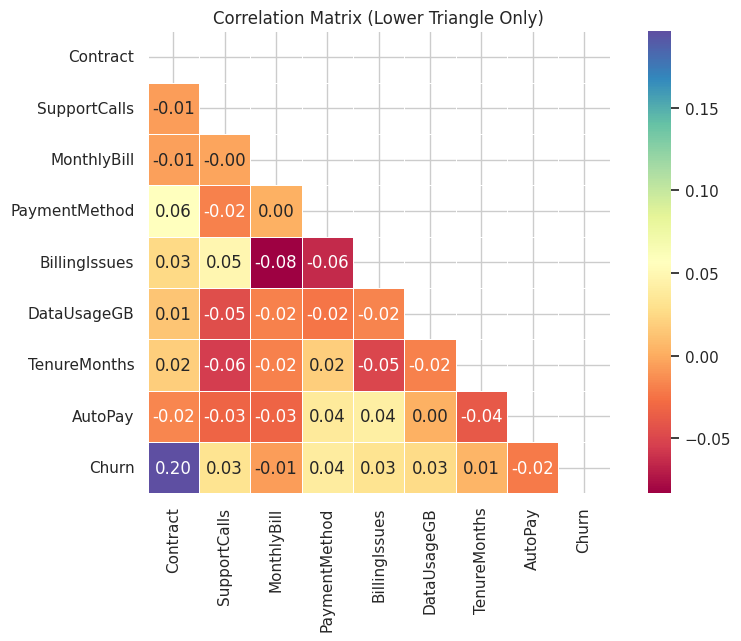

/tmp/ipython-input-411382552.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyBill', data=df, palette='Set3')


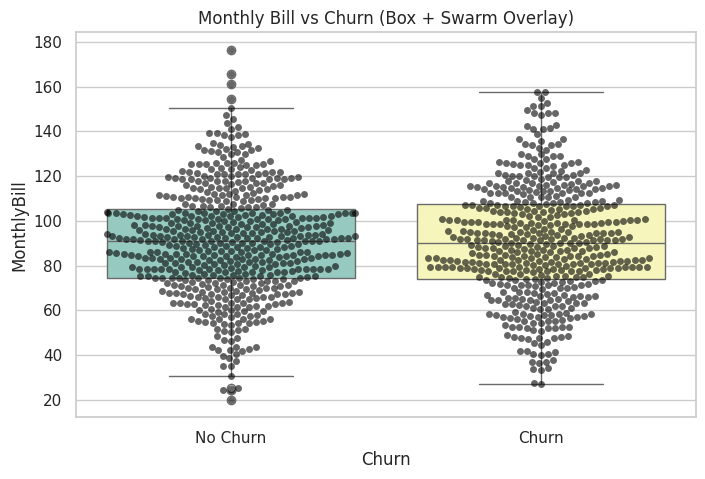

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10,6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Spectral', linewidths=0.5, square=True)
plt.title("Correlation Matrix (Lower Triangle Only)")
plt.show()


plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='MonthlyBill', data=df, palette='Set3')
sns.swarmplot(x='Churn', y='MonthlyBill', data=df, color='black', alpha=0.6)
plt.title("Monthly Bill vs Churn (Box + Swarm Overlay)")
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()





Monthly Bill Distribution by Churn (KDE Plot)



/tmp/ipython-input-2194561617.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn'] == 0], x='MonthlyBill', label='No Churn', shade=True)
/tmp/ipython-input-2194561617.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn'] == 1], x='MonthlyBill', label='Churn', shade=True)


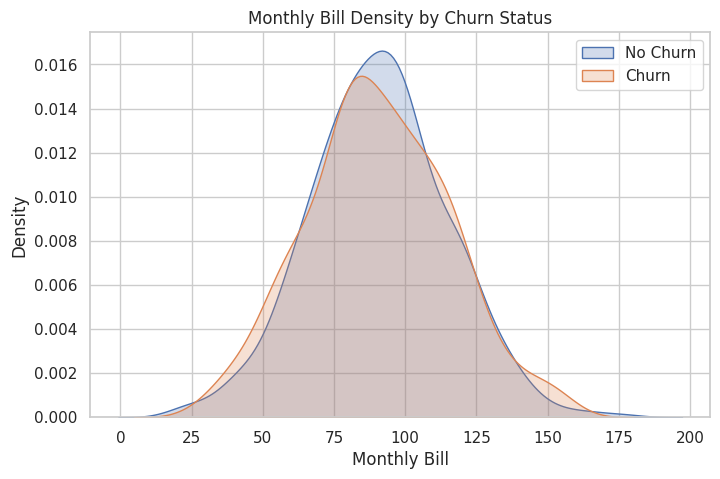

 Avg Monthly Bill (Churned): ₹90.37
 Avg Monthly Bill (Retained): ₹90.71


In [21]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df[df['Churn'] == 0], x='MonthlyBill', label='No Churn', shade=True)
sns.kdeplot(data=df[df['Churn'] == 1], x='MonthlyBill', label='Churn', shade=True)
plt.title("Monthly Bill Density by Churn Status")
plt.xlabel("Monthly Bill")
plt.legend()
plt.show()

avg_churn_bill = df[df['Churn'] == 1]['MonthlyBill'].mean()
avg_no_churn_bill = df[df['Churn'] == 0]['MonthlyBill'].mean()

print(f" Avg Monthly Bill (Churned): ₹{avg_churn_bill:.2f}")
print(f" Avg Monthly Bill (Retained): ₹{avg_no_churn_bill:.2f}")

#5. ML Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000) # Simple baseline model for binary classification
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#6. Model Evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# Predictions
y_pred = model.predict(X_test)
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Confusion Matrix:
 [[89 69]
 [69 74]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.56      0.56       158
           1       0.52      0.52      0.52       143

    accuracy                           0.54       301
   macro avg       0.54      0.54      0.54       301
weighted avg       0.54      0.54      0.54       301

F1 Score: 0.5174825174825175


#7. Feature Importance

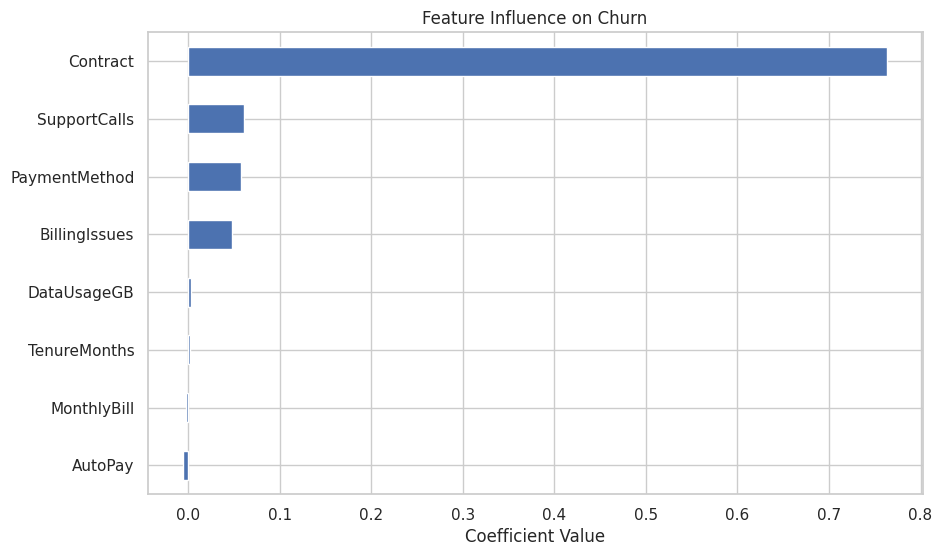

In [24]:
coeffs = pd.Series(model.coef_[0], index=X.columns)
coeffs.sort_values().plot(kind='barh', figsize=(10,6), title='Feature Influence on Churn')
plt.xlabel("Coefficient Value")
plt.show()

# 8. Predict New Customer

In [25]:
new_customer = pd.DataFrame({
    'Contract': [le_dict['Contract'].transform(['Monthly'])[0]],
    'SupportCalls': [4],
    'MonthlyBill': [110.0],
    'PaymentMethod': [le_dict['PaymentMethod'].transform(['CreditCard'])[0]],
    'BillingIssues': [0],
    'DataUsageGB': [85.0],
    'TenureMonths': [12],
    'AutoPay': [le_dict['AutoPay'].transform([1])[0]]
})
pred = model.predict(new_customer) ## Predict churn for new customer input
print("Predicted Churn:", le_dict['Churn'].inverse_transform(pred)[0])

Predicted Churn: Yes
